In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [2]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
from collections import Counter
# Visualization
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from torchvision.transforms import ToTensor
from torchvision.models import vgg16,mnasnet0_5
from torch import nn
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [4]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.005
NUM_WORKERS = 4

In [5]:
class PyTorchLeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=True):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return x,logits

In [6]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters()#(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        _,logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [7]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader


class DataModule(pl.LightningDataModule):
    def __init__(self,train_data,valid_data):
        super().__init__()
        self.train_data=train_data
        self.valid_data=valid_data
        #self.data_path = data_path
        
    def prepare_data(self):
        #datasets.MNIST(root=self.data_path,
        #               download=True)
        self.resize_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.ToTensor()])
        
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        
        self.train, self.valid = self.train_data,self.valid_data

    def train_dataloader(self):
        print(len(self.train))
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = PyTorchLeNet5(
    num_classes=10, grayscale=True)

lightning_model = LightningModel(
    model=pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
#logger = CSVLogger(save_dir="logs/", name="my-model")

In [9]:
transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.ToTensor()])

In [10]:
FashionMNIST('/.', train=True, download=True)
FashionMNIST('/.', train=False, download=True)#data_dir
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
dataset_full = FashionMNIST('/.',train=True,transform=transform)
dataset_train = FashionMNIST('/.',train=True,transform=transform)

#print(type(dataset_full),len(dataset_full)) 
dataset_train, dataset_val,remaining = random_split(dataset_full, [50000,10000,0])
#print(len(dataset_train),type(dataset_train))
dataset_train_original=copy.deepcopy(dataset_train)

In [11]:
torch.manual_seed(1) 
data_module = DataModule(dataset_train, dataset_val)

In [12]:
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(
    save_dir='History',
    name='Fashoin_history'
)

In [13]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    #accelerator="auto",  # Uses GPUs or TPUs if available
    #devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=[csv_logger],
    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

50000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 113.58 min in total.


In [40]:
df=pd.read_csv('History\\Fashoin_history\\version_0\\metrics.csv')#logs/my-model/version_4
df2=pd.read_csv('logs\\my-model\\version_8\\metrics.csv')
df2

,train_acc,epoch,step,valid_loss,valid_acc,train_loss
0,0.078125,0,2,NaN,NaN,NaN
1,NaN,0,2,2.304383,0.0951,NaN
2,0.078125,1,5,NaN,NaN,NaN
3,NaN,1,5,2.303070,0.0951,NaN
4,0.072917,2,8,NaN,NaN,NaN
...,...,...,...,...,...,...
163,NaN,79,246,1.118589,0.5843,NaN
164,0.589489,79,257,NaN,NaN,NaN
165,NaN,79,257,1.097085,0.5993,NaN
166,0.601042,79,272,NaN,NaN,NaN


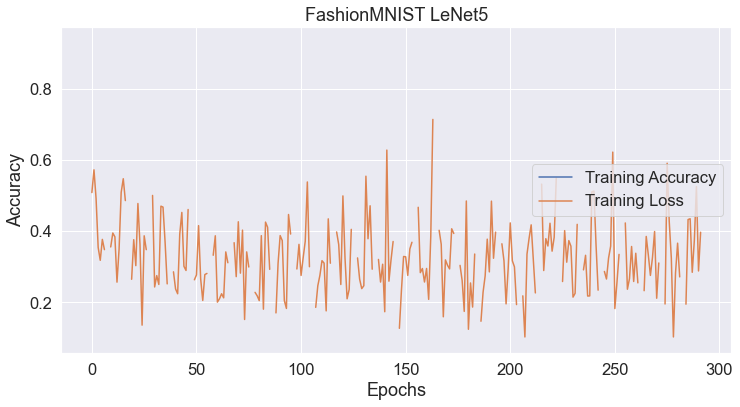

In [39]:
#print(model.history.keys())
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.plot(df2.train_acc)
plt.plot(df.train_loss)
plt.title('FashionMNIST LeNet5')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Training Loss'], loc='center right')
plt.savefig('Results\\FashionMNIST_history.png')
plt.show()

In [16]:
def prepare_test_embeddings(dataset_train):

    test_loader = DataLoader(dataset=dataset_train, 
                                     batch_size=BATCH_SIZE, 
                                     drop_last=False,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)
    test_dataloader = test_loader

    all_true_labels = []
    all_predicted_labels = []
    #test_imgs = torch.zeros((0, 1, 32, 32), dtype=torch.float32)
    test_embeddings = torch.zeros((0, 400), dtype=torch.float32)
    for batch in test_dataloader:
        features, labels = batch

        with torch.no_grad():  # since we don't need to backprop
            embeddings, logits = lightning_model(features)
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        predicted_labels = torch.argmax(logits, dim=1)
        all_predicted_labels.append(predicted_labels)
        all_true_labels.append(labels)
        #test_imgs = torch.cat((test_imgs, features.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)

    test_embeddings = np.array(test_embeddings)
    all_predicted_labels = torch.cat(all_predicted_labels)
    all_true_labels = torch.cat(all_true_labels)
    all_predicted_labels=np.array(all_predicted_labels)
    all_true_labels=np.array(all_true_labels)
    
    
    accuracy = accuracy_score(all_predicted_labels, all_true_labels)#,average='micro')
    recall = recall_score(all_predicted_labels, all_true_labels,average='micro')
    precision = precision_score(all_predicted_labels, all_true_labels,average='micro')
    f1_score1 = f1_score(all_predicted_labels, all_true_labels,average='micro')
    
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'precision: {precision*100:.2f}%')
    print(f'recall: {recall*100:.2f}%')
    print(f'f1_score1: {f1_score1*100:.2f}%')

    test_acc = np.sum(all_predicted_labels == all_true_labels)
    final_test_acc = test_acc/len(test_embeddings)
    #print(final_test_acc)
    #all_predicted_labels[:5]
    return test_embeddings,all_true_labels,all_predicted_labels,final_test_acc

## Shows some of Fashion data

In [17]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

In [18]:
import itertools
k = int(np.floor(sample_at/batch_size))
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

#plt.figure()
#for i in range(32):
#    plt.subplot(4,8,i+1)
#    arr=np.squeeze(data)
#    plt.imshow(my_sample[0][i][0], cmap='gray')
#    plt.axis('off')
#    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

tensor([8, 9, 4, 5, 8, 6, 1, 7, 9, 2, 9, 9, 7, 3, 8, 9, 6, 8, 6, 5, 1, 6, 9, 6,
        0, 3, 2, 9, 5, 2, 8, 5])


## prepare_test_embeddings

In [19]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score,accuracy_score
# calculates recall for 1:100 dataset with 90 tp and 10 fn
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score

In [20]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Accuracy: 87.03%
precision: 87.03%
recall: 87.03%
f1_score1: 87.03%
Initial Testing accuracy:   0.8703


In [21]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
#print(accuracy_score(test_targets,test_predictions, average='macro'))
c_matrix = metrics.confusion_matrix(test_targets,test_predictions)
print(metrics.classification_report(test_targets,test_predictions, digits=3))

              precision    recall  f1-score   support

           0      0.829     0.812     0.821      1000
           1      0.981     0.970     0.975      1000
           2      0.832     0.754     0.791      1000
           3      0.883     0.868     0.875      1000
           4      0.736     0.850     0.789      1000
           5      0.972     0.938     0.955      1000
           6      0.652     0.636     0.644      1000
           7      0.937     0.939     0.938      1000
           8      0.956     0.967     0.962      1000
           9      0.936     0.969     0.952      1000

    accuracy                          0.870     10000
   macro avg      0.872     0.870     0.870     10000
weighted avg      0.872     0.870     0.870     10000



In [42]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        sns.set(font_scale=1.5)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="cividis")#cividis
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Results\\FashionMNIST_confusion_matrix.png')

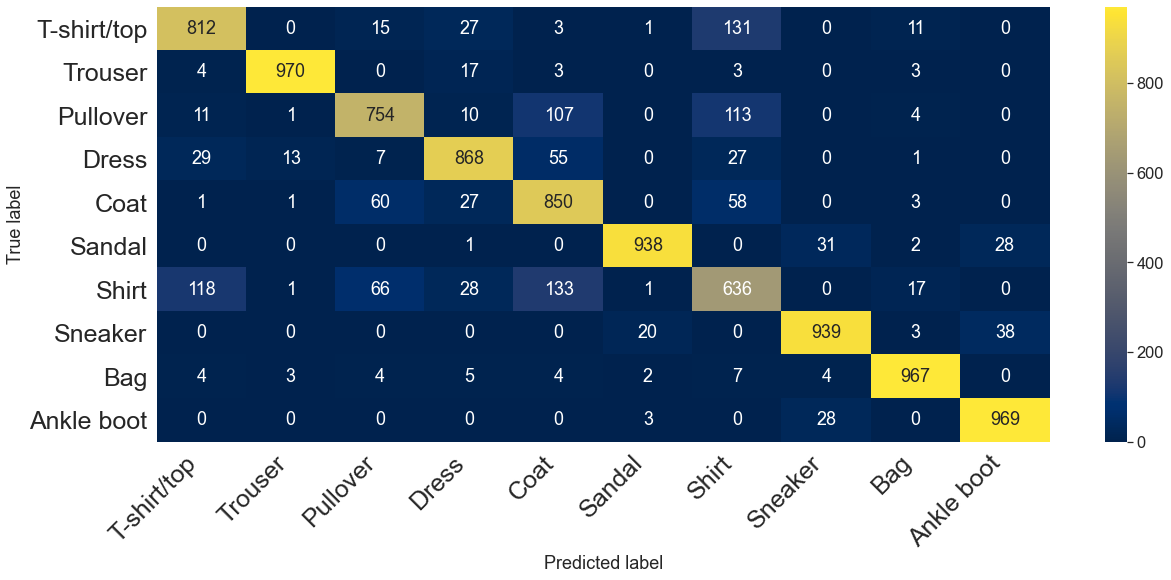

In [43]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
confusion_matrix(c_matrix, class_names, figsize = (20,8), fontsize=25)